# CS 109A/AC 209A/STAT 121A Data Science: Homework 4
**Harvard University**<br>
**Fall 2016**<br>
**Instructors: W. Pan, P. Protopapas, K. Rader**<br>
**Due Date: ** Wednesday, October 5th, 2016 at 11:59pm

Download the `IPython` notebook as well as the data file from Vocareum and complete locally.

To submit your assignment, in Vocareum, upload (using the 'Upload' button on your Jupyter Dashboard) your solution to Vocareum as a single notebook with following file name format:

`last_first_CourseNumber_HW4.ipynb`

where `CourseNumber` is the course in which you're enrolled (CS 109a, Stats 121a, AC 209a). Submit your assignment in Vocareum using the 'Submit' button.

**Avoid editing your file in Vocareum after uploading. If you need to make a change in a solution. Delete your old solution file from Vocareum and upload a new solution. Click submit only ONCE after verifying that you have uploaded the correct file. The assignment will CLOSE after you click the submit button.**

Problems on homework assignments are equally weighted. The Challenge Question is required for AC 209A students and optional for all others. Student who complete the Challenge Problem as optional extra credit will receive +0.5% towards your final grade for each correct solution. 

Import libraries

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression as Lin_Reg
from sklearn.linear_model import Ridge as Ridge_Reg
from sklearn.linear_model import Lasso as Lasso_Reg
from statsmodels.regression.linear_model import OLS
import sklearn.preprocessing as Preprocessing
import itertools as it
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
import scipy as sp
from itertools import combinations
%matplotlib inline

## Problem 0: Basic Information

Fill in your basic information. 

### Part (a): Your name

[Last: Zhang, First: Linying]

### Part (b): Course Number

[AC 209a]

### Part (c): Who did you work with?

[First and Land names of students with whom you have collaborated]

**All data sets can be found in the ``datasets`` folder and are in comma separated value (CSV) format**

## Problem 1: Variable selection and regularization

The data set for this problem is provided in ``dataset_1.txt`` and contains 10 predictors and a response variable.

### Part (a): Analyze correlation among predictors
- By visually inspecting the data set, do find that some of the predictors are correlated amongst themselves?


- Compute the cofficient of correlation between each pair of predictors, and visualize the matrix of correlation coefficients using a heat map. Do the predictors fall naturally into groups based on the correlation values?


- If you were asked to select a minimal subset of predictors based on the correlation information in order to build a good regression model, how many predictors will you pick, and which ones will you choose? 

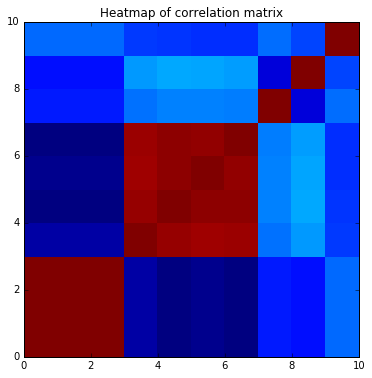

In [43]:
# Load data
data = np.loadtxt('dataset_1.txt', delimiter=',', skiprows=1)

# Split predictors and response
x = data[:, :-1]
y = data[:, -1]

# Compute matrix of correlation coefficients
corr_matrix = np.corrcoef(x.T)

# Display heat map 
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.pcolor(corr_matrix)

ax.set_title('Heatmap of correlation matrix')

plt.show()

### Part (b): Selecting minimal subset of predictors

- Apply the variable selection methods discussed in class to choose a minimal subset of predictors that yield high prediction accuracy:
    
    - Exhaustive search
    
    - Step-wise forward selection **or** Step-wise backward selection  

&emsp;&nbsp;&nbsp; In each method, use the Bayesian Information Criterion (BIC) to choose the subset size.

- Do the chosen subsets match the ones you picked using the correlation matrix you had visualized in Part (a)?

**Note**: You may use the `statsmodels`'s `OLS` module to fit a linear regression model and evaluate BIC. You may **not** use library functions that implement variable selection.

In [4]:
### Best Subset Selection
min_bic = 1e10 # set some initial large value for min BIC score
best_subset = [] # best subset of predictors

# Create all possible subsets of the set of 10 predictors
predictor_set = set(range(10)) # predictor set = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

# Repeat for every possible size of subset
for size_k in range(10): 
    # Create all possible subsets of size 'size', 
    # using the 'combination' function from the 'itertools' library
    subsets_of_size_k = it.combinations(predictor_set, size_k + 1) 
    
    max_r_squared = -1e10 # set some initial small value for max R^2 score
    best_k_subset = [] # best subset of predictors of size k
    
    # Iterate over all subsets of our predictor set
    for predictor_subset in subsets_of_size_k:    
        # Use only a subset of predictors in the training data
        x_subset = x[:, predictor_subset]

        # Fit and evaluate R^2
        model = OLS(y, x_subset)
        results = model.fit()
        r_squared = results.rsquared
        
        # Update max R^2 and best predictor subset of size k
        # If current predictor subset has a higher R^2 score than that of the best subset 
        # we've found so far, remember the current predictor subset as the best!
        if(r_squared > max_r_squared): 
            max_r_squared = r_squared
            best_k_subset = predictor_subset[:]
                

    # Use only the best subset of size k for the predictors
    x_subset = x[:, best_k_subset]
        
    # Fit and evaluate BIC of the best subset of size k
    model = OLS(y, x_subset)
    results = model.fit()
    bic = results.bic
    
    # Update minimum BIC and best predictor subset
    # If current predictor has a lower BIC score than that of the best subset 
    # we've found so far, remember the current predictor as the best!
    if(bic < min_bic): 
        min_bic = bic
        best_subset = best_k_subset[:]
    
print('Best subset by exhaustive search:')
print sorted(best_subset)

Best subset by exhaustive search:
[0, 5, 7, 8, 9]


In [5]:
### Step-wise Forward Selection
d = x.shape[1] # total no. of predictors

# Keep track of current set of chosen predictors, and the remaining set of predictors
current_predictors = [] 
remaining_predictors = range(d)

# Set some initial large value for min BIC score for all possible subsets
global_min_bic = 1e10 

# Keep track of the best subset of predictors
best_subset = [] 

# Iterate over all possible subset sizes, 0 predictors to d predictors
for size in range(d):    
    max_r_squared = -1e10 # set some initial small value for max R^2
    best_predictor = -1 # set some throwaway initial number for the best predictor to add
    bic_with_best_predictor = 1e10 # set some initial large value for BIC score   
        
    # Iterate over all remaining predictors to find best predictor to add
    for i in remaining_predictors:
        # Make copy of current set of predictors
        temp = current_predictors[:]
        # Add predictor 'i'
        temp.append(i)
                                    
        # Use only a subset of predictors in the training data
        x_subset = x[:, temp]
        
        # Fit and evaluate R^2
        model = OLS(y, x_subset)
        results = model.fit()
        r_squared = results.rsquared
        
        # Check if we get a higher R^2 value than than current max R^2, if so, update
        if(r_squared > max_r_squared):
            max_r_squared = r_squared
            best_predictor = i
            bic_with_best_predictor = results.bic
    
    # Remove best predictor from remaining list, and add best predictor to current list
    remaining_predictors.remove(best_predictor)
    current_predictors.append(best_predictor)
    
    # Check if BIC for with the predictor we just added is lower than 
    # the global minimum across all subset of predictors
    if(bic_with_best_predictor < global_min_bic):
        best_subset = current_predictors[:]
        global_min_bic = bic_with_best_predictor
    
print 'Step-wise forward subset selection:'
print sorted(best_subset) # add 1 as indices start from 0

Step-wise forward subset selection:
[0, 5, 7, 8, 9]


### Part (c): Apply Lasso and Ridge regression

- Apply Lasso regression with regularization parameter $\lambda = 0.01$ and fit a regression model.

    - Identify the predictors that are assigned non-zero coefficients. Do these correspond to  the correlation matrix in Part (a)?


- Apply Ridge regression with regularization parameter $\lambda = 0.01$ and fit a regression model.

    - Is there a difference between the model parameters you obtain different and those obtained from Lasso regression? If so, explain why.

    - Identify the predictors that are assigned non-zero coefficients. Do these correspond to  the correlation matrix in Part (a)?


- Is there anything peculiar that you observe about the coefficients Ridge regression assigns to the first three predictors? Do you observe the same with Lasso regression? Give an explanation for your observation.

**Note**: You may use the `statsmodels` or `sklearn` to perform Lasso and Ridge regression.

In [6]:
# Lasso regression
reg = Lasso_Reg(alpha = 0.01)
reg.fit(x, y)
coefficients = reg.coef_

print 'Lasso:'
print 'Coefficients:', coefficients
print  'Predictors with non-zero coefficients:', [i for i, item in enumerate(coefficients) if abs(item) > 0]

Lasso:
Coefficients: [  2.71741712e-02   2.87182897e-17   2.87182897e-17  -0.00000000e+00
  -2.53280567e-02  -0.00000000e+00  -0.00000000e+00   4.39732115e-02
  -4.06121850e-01  -2.22604739e-01]
Predictors with non-zero coefficients: [0, 1, 2, 4, 7, 8, 9]


In [7]:
# Ridge regression: Fit and evaluate 
reg = Ridge_Reg(alpha = 0.01)
reg.fit(x, y)
coefficients = reg.coef_

print 'Ridge:'
print 'Coefficients:', coefficients
print 'Predictors with non-zero coefficients:', [i for i, item in enumerate(coefficients) if abs(item) > 0]

Ridge:
Coefficients: [ 0.04353543  0.04353543  0.04353543  0.55217415 -0.19706852 -0.61421737
  0.30484213  0.18742866 -0.50083242 -0.35908145]
Predictors with non-zero coefficients: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


## Problem 2: Cross-validation and Bootstrapping
In this problem, you will work with an expanded version of the automobile pricing data set you analyzed in Homework 3. The data set is contained ``dataset_2.txt``, with 26 attribues (i.e. predictors) for each automobile and corresponding prices. 

### Part(a): Encode categorical attributes and fill missing values
Identify the categorical attributes in the data. Replace their values with the one-hot binary encoding. You may do this using the `get_dummies()` function in `pandas`. If you do this task correctly, you should get a total of 69 predictors after the encoding.


In [122]:
# Load data into pandas dataframe
df = pd.read_csv('dataset_2.txt')

# Separate predictors (x) and response(y)
x_df = df.iloc[:, :-1]
y_df = df.iloc[:, -1]

# Create a new dataframe to store one-hot encoding of attributes
x_df_expanded = pd.DataFrame({})

for column in x_df.columns:
    
    # Check if categorical: less than 8 unique values or is string value (dtype: 'object)
    if len(x_df[column].unique())<8 or x_df[column].dtype == np.dtype('object'):
        
        # use one-hot encoding for this column
        encoding = pd.get_dummies(x_df[column])
        
        # append expanded attributes to dataframe 
        x_df_expanded = pd.concat([x_df_expanded, encoding], axis = 1)

    else:
        x_df_expanded = pd.concat([x_df_expanded, x_df[column]], axis = 1)
print "The shape of expanded x dataframe:", x_df_expanded.shape

The shape of expanded x dataframe: (205, 69)


### Part (b): Apply regular linear regression
- Split the data set into train and test sets, with the first 25% of the data for training and the remaining for testing.  


- Use regular linear regression to fit a model to the training set and evaluate the R^2 score of the fitted model on both the training and test sets. What do you observe about these values?


- You had seen in class that the R^2 value of a least-squares fit to a data set would lie between 0 and 1. Is this true for the test R^2 values reported above? If not, give a reason for why this is the case.


- Is there a need for regularization while fitting a linear model to this data set?

**Note**: You may use the `statsmodels` or `sklearn` to fit a linear regression model and evaluate the fits.

In [123]:
# Split the dataset: first 25% into training and remaining for testing
x_train = x_df_expanded.iloc[:51, :]
y_train = y_df.iloc[:51]
x_test = x_df_expanded.iloc[51:, :]
y_test = y_df.iloc[51:]

# Fit linear regression model on training
regression = Lin_Reg()
regression.fit(x_train,y_train)

# Evaluate model by R^2
r_squared_train = regression.score(x_train, y_train)
print "The R^2 of training dataset is:", r_squared_train

# Evaluate fit on testing dataset by R^2
r_squared_test = regression.score(x_test, y_test)
print "The R^2 of testing dataset is:", r_squared_test

The R^2 of training dataset is: 1.0
The R^2 of testing dataset is: -5.97542556683


In [124]:
# Perform regularization on the continuous variables on training dataset and testing dataset

# First separate continuous variables from categorical variables
    # The reason we only standardize continuous variables is because ridge regression penalizes large coefficients,
    # thus it makes sense to standardize continuous variables to the same scale so as to have their 
    # coefficients at the same magnitude.
    # Categorical variables are all between 0 and 1, hence there is no problem regarding 
    # the magnitude of their coefficient.

cont_index = []
cat_index = []
for column in x_df.columns:
    
    # Check if categorical: less than 8 unique values or is string value (dtype: 'object)
    if len(x_df[column].unique())<8 or x_df[column].dtype == np.dtype('object'):
        cat_index.append(column)
    else:
        cont_index.append(column)

# find the continuous variables in the x_train and x_test 
x_train_cont = x_train[cont_index]
x_test_cont = x_test[cont_index]

# Scale the data by dividing both x_train and x_test by the std of X_TRAIN!!
# The rationale is that the model we develop is based on the standardization of x_train, 
# hence if we standardize x_test by dividing the std of x_test, then we have two standardization methods to the two datasets 
# and they are not exchangeable.
x_train_cont_standardized = x_train_cont / x_train_cont.std(axis=0)
x_test_cont_standardized = x_test_cont / x_train_cont.std(axis=0)

# To replace the original continuous variable with standardized continuous variable
# First, delete the unstandardized continuous variables
x_train.drop(x_train[cont_index], axis=1, inplace = True)
x_test.drop(x_test[cont_index], axis=1, inplace = True)

# Concatenate the matrix of standardized continuous variables to the training and testing sets.
x_train_standardized = pd.concat([x_train_cont_standardized, x_train], axis=1)
x_test_standardized = pd.concat([x_test_cont_standardized, x_test], axis=1)

# Fit linear regression model on training
regression = Lin_Reg()
regression.fit(x_train_standardized, y_train)

# Evaluate model by R^2
r_squared_train = regression.score(x_train_standardized, y_train)
print "The R^2 of training dataset is:", r_squared_train

# Evaluate fit on testing dataset by R^2
r_squared_test = regression.score(x_test_standardized, y_test)
print "The R^2 of testing dataset is:", r_squared_test

The R^2 of training dataset is: 1.0
The R^2 of testing dataset is: -10.9344918837


/Users/Linying/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Linying/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Part (c): Apply Ridge regression

- Apply Ridge regression on the training set for different values of the regularization parameter $\lambda$ in the range $\{10^{-7}, 10^{-6}, \ldots, 10^7\}$. Evaluate the R^2 score for the models you obtain on both the train and test sets. Plot both values as a function of $\lambda$. 


- Explain the relationship between the regularization parameter and the training and test R^2 scores.


- How does the best test R^2 value obtained using Ridge regression compare with that of plain linear regression? Explain.

**Note**: You may use the `statsmodels` or `sklearn` to fit a ridge regression model and evaluate the fits.

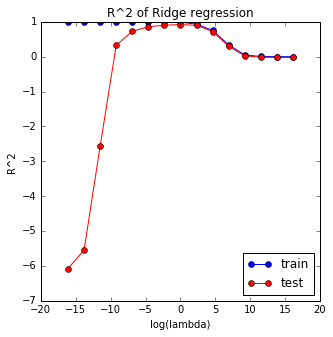

In [126]:
# Run for different values of lambda 
lambda_min = -7
lambda_max = 7

num_lambdas = 15
num_predictors = x_train.shape[1]

lambdas= np.linspace(lambda_min,lambda_max, num_lambdas)

train_r_squared = np.zeros(num_lambdas)
test_r_squared = np.zeros(num_lambdas)

for ind, i in enumerate(lambdas):    
    # Fit ridge regression on train set
    reg = Ridge_Reg(alpha = 10**i)
    reg.fit(x_train_standardized, y_train)
       
    # Evaluate train & test performance
    train_r_squared[ind] = reg.score(x_train_standardized, y_train)
    test_r_squared[ind] = reg.score(x_test_standardized, y_test)

# plot R^2 of training and testing dataset against parameter lambda
plt.figure(figsize=(5,5))
h = np.log(10**lambdas)
plt.plot(h, train_r_squared, 'bo-', label = 'train')
plt.plot(h, test_r_squared, 'ro-', label = 'test')
plt.title('R^2 of Ridge regression');plt.xlabel('log(lambda)');plt.ylabel('R^2')
plt.legend(loc='best')
plt.show()

### Part (d): Tune regularization parameter using cross-validation and bootstrapping
-  Evaluate the performance of the Ridge regression for different regularization parameters $\lambda$ using 5-fold cross validation **or** bootstrapping on the training set. 

    - Plot the cross-validation (CV) or bootstrapping R^2 score as a function of $\lambda$. 
    
    - How closely does the CV score or bootstrapping score match the R^2 score on the test set? Does the model with lowest CV score or bootstrapping score correspond to the one with maximum R^2 on the test set?
    
    - Does the model chosen by CV or bootstrapping perform better than plain linear regression?

**Note**: You may use the `statsmodels` or `sklearn` to fit a linear regression model and evaluate the fits. You may also use `kFold` from `sklearn.cross_validation`. 

/Users/Linying/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Linying/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


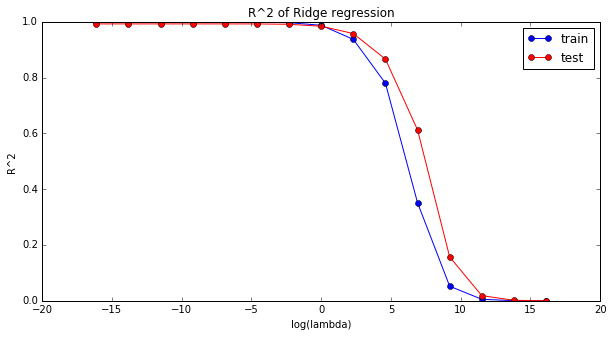

In [87]:
# I use bootstrapping to evaluate the performance of the Ridge regression for 
# different regularization parameters  λ

# Size of the data set
n = x_df_expanded.shape[0]

# No. of subsamples
num_samples = 20

# Run for different values of lambda 
lambda_min = -7
lambda_max = 7

num_lambdas = 15
num_predictors = x_df_expanded.shape[1]

lambdas= np.linspace(lambda_min,lambda_max, num_lambdas)


# Create arrays to store r_squared for all subsamples
train_r_squared = np.zeros([num_samples, num_lambdas])
test_r_squared = np.zeros([num_samples, num_lambdas])

for i in range(num_samples):

    # Generate a random subsample of data points
    # This is the bootstrap
    perm = np.random.randint(low=0, high=n, size=n) # Generate a list of indices 0 to n and permute it    
    x_subsample = x_df_expanded.ix[perm]
    y_subsample = y_df.ix[perm] 
    
    # Split the dataset: first 25% into training and remaining for testing
    x_train = x_subsample.iloc[:51, :]
    y_train = y_subsample.iloc[:51]
    x_test = x_subsample.iloc[51:, :]
    y_test = y_subsample.iloc[51:]
    
    # find the continuous variables in the x_train and x_test 
    x_train_cont = x_train[cont_index]
    x_test_cont = x_test[cont_index]

    # Scale the data by dividing both x_train and x_test by the std of X_TRAIN!!
    x_train_cont_standardized = x_train_cont / x_train_cont.std(axis=0)
    x_test_cont_standardized = x_test_cont / x_train_cont.std(axis=0)

    # To replace the original continuous variable with standardized continuous variable
    # First, delete the unstandardized continuous variables
    x_train.drop(x_train[cont_index], axis=1, inplace = True)
    x_test.drop(x_test[cont_index], axis=1, inplace = True)

    # Concatenate the matrix of standardized continuous variables to the training and testing sets.
    x_train_standardized = pd.concat([x_train_cont_standardized, x_train], axis=1)
    x_test_standardized = pd.concat([x_test_cont_standardized, x_test], axis=1)

    # Fit ridge regression 
    for ind, k in enumerate(lambdas):
        
        # Fit ridge regression on train set
        reg = Ridge_Reg(alpha = 10**k)
        reg.fit(x_train_standardized, y_train)
        
        # Evaluate train performance, and store r_squared
        train_r_squared[i, ind] = reg.score(x_train_standardized, y_train)
        
        # Fit ridge regression on test set
        reg.fit(x_test_standardized, y_test)
        
         # Evaluate test performance, and store r_squared
        test_r_squared[i, ind] = reg.score(x_test_standardized, y_test)
        
# Calculate mean of R^2 for each lambda
r_sqr_mean_train = np.zeros(num_lambdas)
r_sqr_mean_test = np.zeros(num_lambdas)

for i in range(num_lambdas):
    r_sqr_mean_train[i] = train_r_squared[:, i].mean()
    r_sqr_mean_test[i] = test_r_squared[:,i].mean()
        
# plot R^2 of training and testing dataset against parameter lambda
plt.figure(figsize=(10,5))
h = np.log(10**lambdas)
plt.plot(h, r_sqr_mean_train, 'bo-', label = 'train')
plt.plot(h, r_sqr_mean_test, 'ro-', label = 'test')
plt.title('Average R^2 of Ridge regression');plt.xlabel('log(lambda)');plt.ylabel('R^2')
plt.legend(loc='best')
plt.show()

## Problem 3: Ridge regression *via* ordinary least-squares regression

We present an approach to implement Ridge regression using oridinary least-squares regression. Given a matrix of responses $\mathbf{X} \in \mathbb{R}^{n\times p}$ and response vector $\mathbf{y} \in \mathbb{R}^{n}$, one can implement Ridge regression with regularization parameter $\lambda$ as follows:

- Augment the matrix of predictors $\mathbf{X}$ with $p$ new rows containing the scaled identity matrix $\sqrt{\lambda}\mathbf{I} \in \mathbb{R}^{p \times p}$, i.e.
$$\overline{\mathbf{X}} \,=\, 
\begin{bmatrix}
X_{11} & \ldots & X_{1p}\\
\vdots & \ddots & \vdots\\
X_{n1} & \ldots & X_{np}\\
\sqrt{\lambda} & \ldots & 0\\
\vdots & \ddots & \vdots\\
0 & \ldots & \sqrt{\lambda}
\end{bmatrix}
\,\in\,
\mathbb{R}^{(n+p)\times p}
.
$$


- Augment the response vector $\mathbf{y}$ with a column of $p$ zeros, i.e.
$$
\overline{\mathbf{y}} \,=\, 
\begin{bmatrix}
y_{1}\\
\vdots\\
y_{n}\\
0\\
\vdots\\
0
\end{bmatrix}
\,\in\,
\mathbb{R}^{n+p}.
$$


- Apply ordinary least-squares regression on the augmented data set $(\overline{\mathbf{X}}, \overline{\mathbf{y}})$.

### Part (a): Show the proposed approach implements Ridge regression
Show that the approach proposed above implements Ridge regression with parameter $\lambda$.

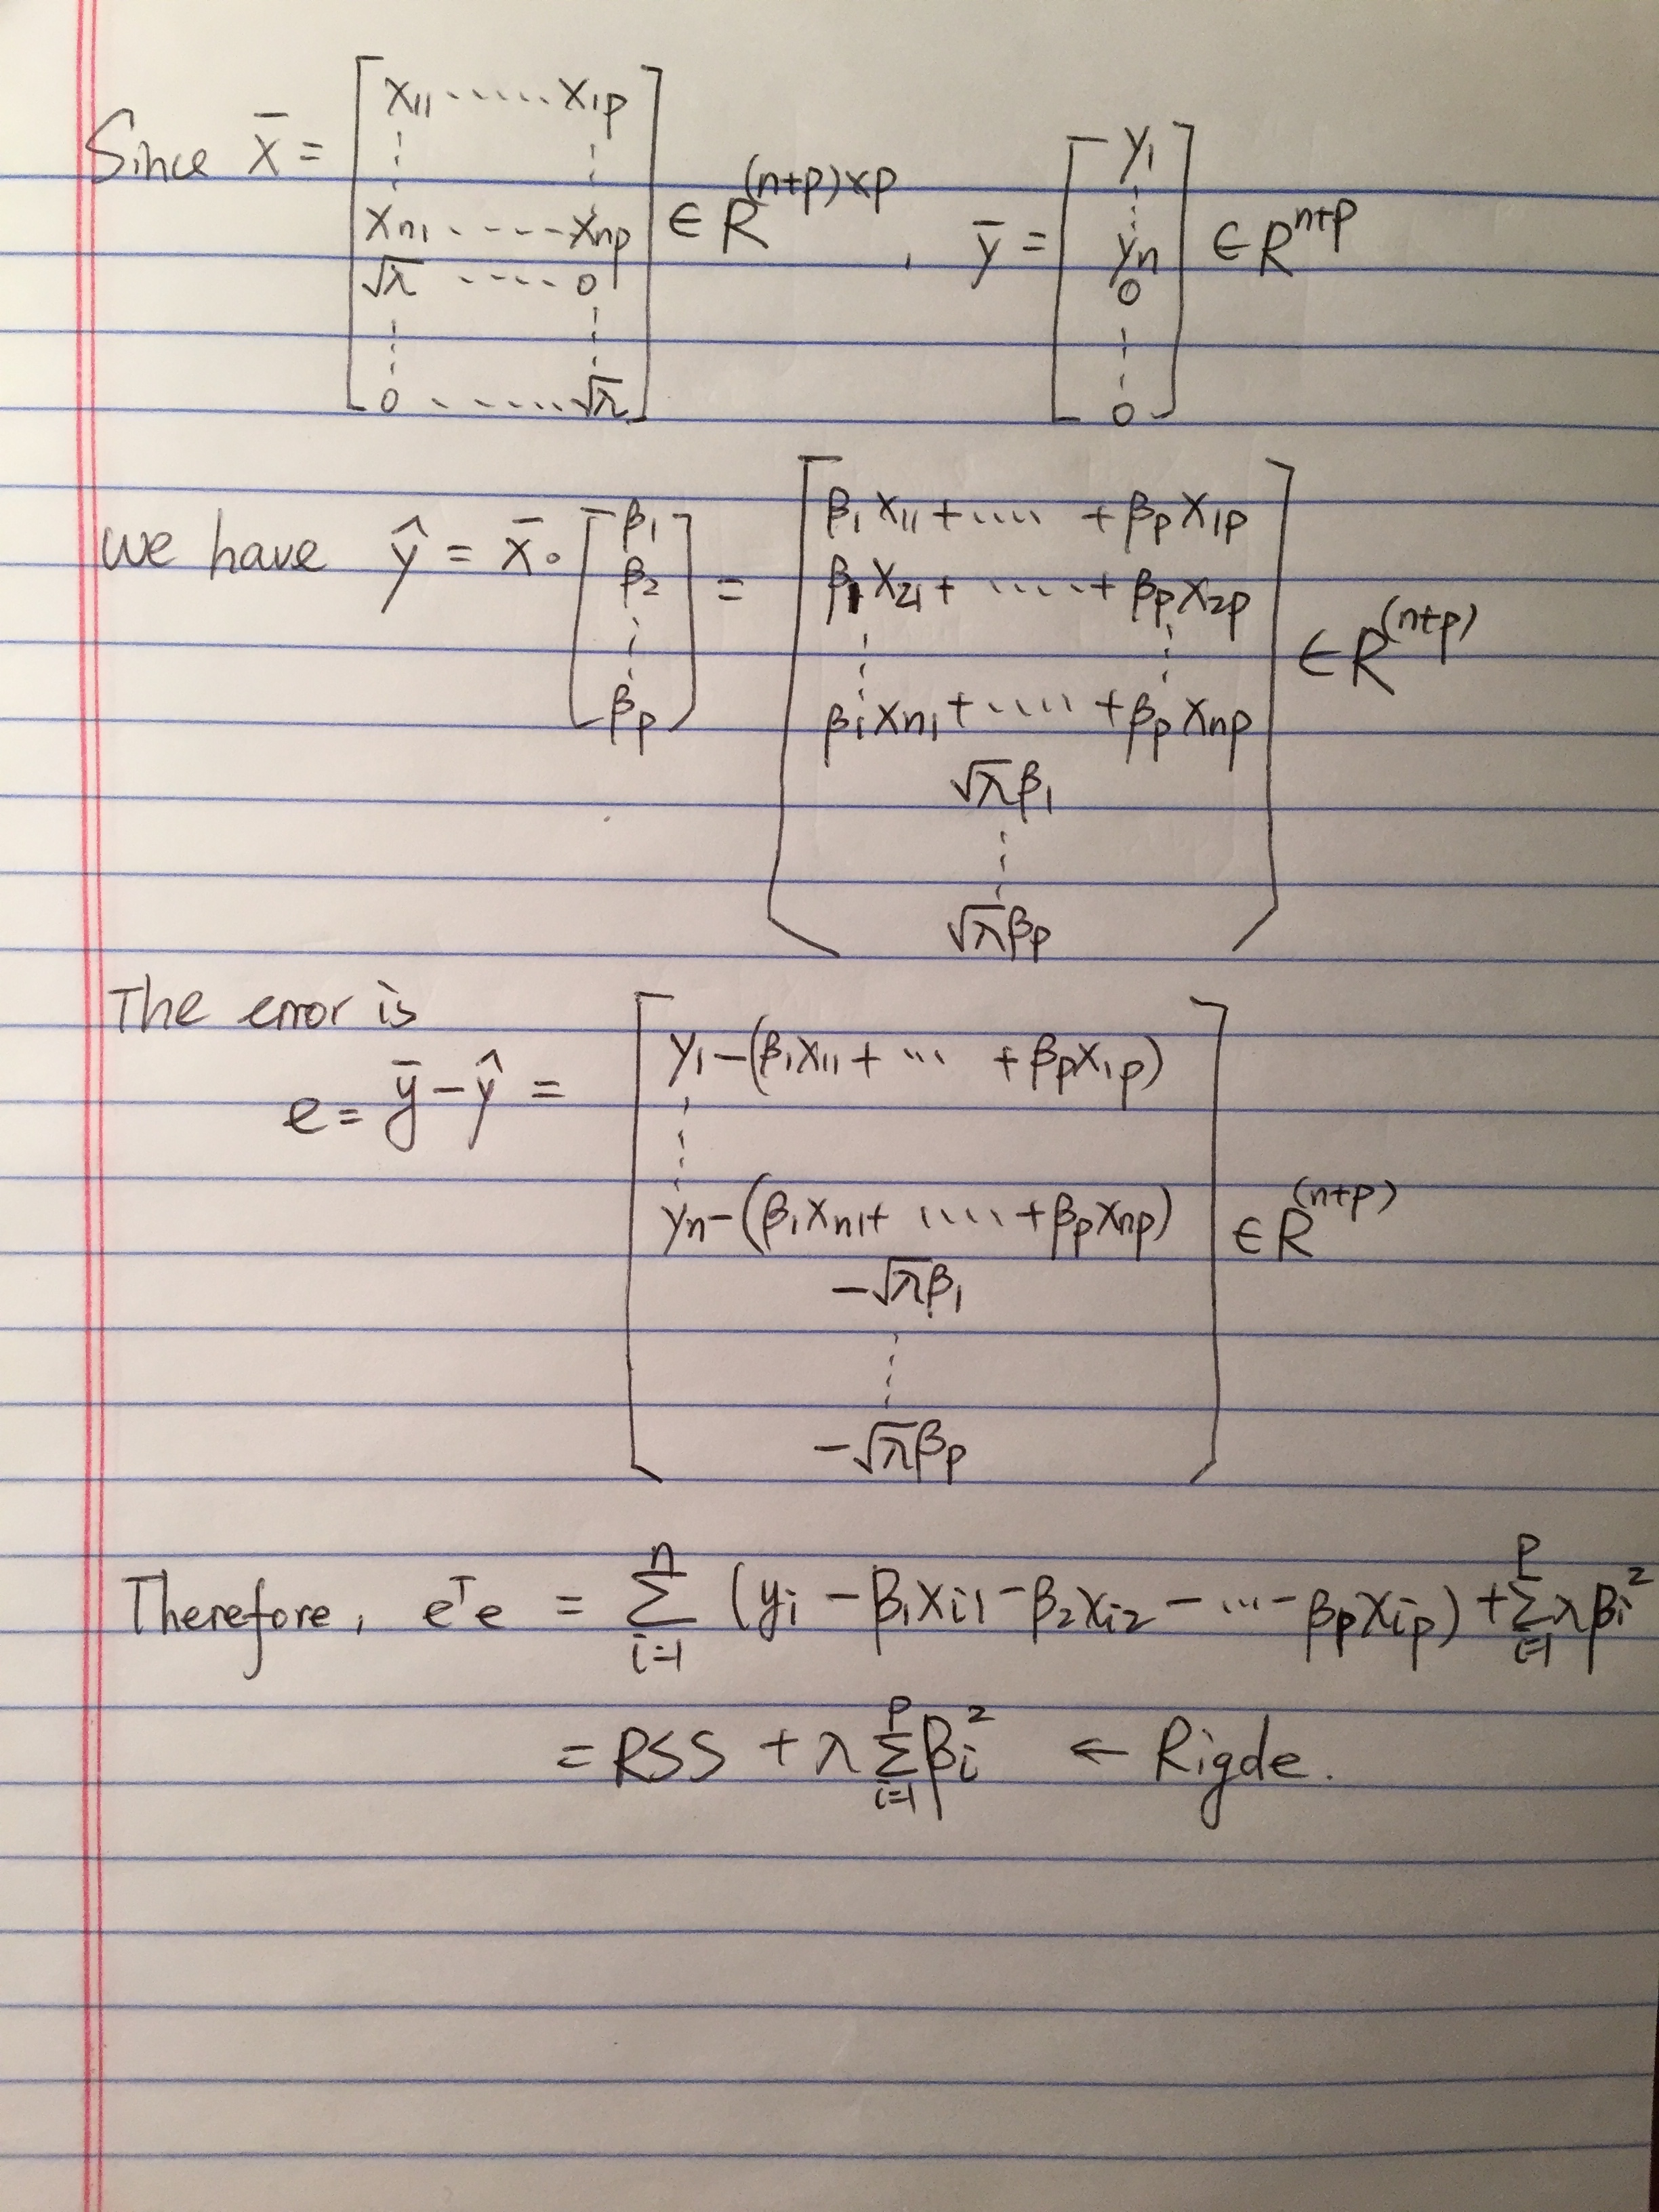

In [165]:
from IPython.display import Image
Image("Zhang_Linying_AC209_HW4_P3(a).JPG")

### Part (b): Debug our implementation of ridge regression
You're a grader for CS109A, the following is an implemention of Ridge regression (via the above approach) submitted by a student. The dataset is ``dataset_3.txt``. The regression model is fitted to a training set, and the R^2 scores of the fitted model on the training and test sets are plotted as a function of the regularization parameter. Grade this solution according to the following rubric (each category is equally weighted): 

- correctness

- interpretation (if applicable)

- code/algorithm design

- presentation

In addition to providing an holistic grade (between 0 to 5), provide a corrected version of this code that is submission quality.

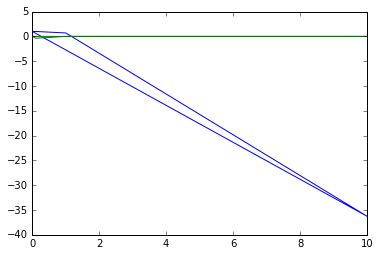

In [14]:
# Fit
def ridge(x_train, y_train, reg_param):
    n=np.shape(x_train)[0]
    x_train=np.concatenate((x_train,reg_param*np.identity(n)),axis=1)
    y_train_=np.zeros((n+np.shape(x_train)[1],1))
    for c in range(n):
        y_train_[c]= y_train[c]
    import sklearn
    model = sklearn.linear_model.LinearRegression()
    model.fit(x_train,y_train.reshape(-1,1))
    return model

# Score
def score(m,x_test,y_test, reg_param):
    n=np.shape(x_train)[0]
    x_test=np.concatenate((x_test,reg_param*np.identity(n)),axis=1)
    y_test_=np.zeros((n+np.shape(x_test)[1],1))
    for c in range(n):
        y_test_[c]= y_test[c]
    return m.score(x_test,y_test.reshape(-1,1))

# Load
data = np.loadtxt('dataset_3.txt', delimiter=',')
n = data.shape[0]
n = int(np.round(n*0.5))
x_train = data[0:n,0:100]
y_train = data[0:n,100]
x_test = data[n:2*n,0:100]
y_test = data[n:2*n,100]

# Params
a=np.zeros(5)
for i in range(-2,2):
    a[i+2]=10**i

# Iterate
rstr =np.zeros(5)
rsts =np.zeros(5)
for j in range(0,5):    
    m =ridge(x_train,y_train,a[i])
    rstr[j]=score(m,x_train,y_train,a[j])
    rsts[i]=score(m,x_test,y_test,a[i])

# Plot
plt.plot(a,rstr)
plt.plot(a,rsts)

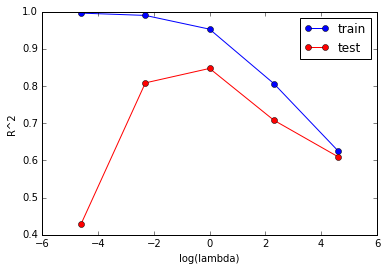

In [89]:
import sklearn

# define a ridge function that builds a linear regression model with inputs:
    # x in the training set
    # y in the training set
    # the ridge regression paramater lambda
    
def ridge(x_train, y_train, reg_param):
    p = np.shape(x_train)[1] # find the number of columns in x_train
    n = np.shape(x_train)[0] #find the number of rows in x_train
    
    # Concatenate x matrix and the sqrt(reg_param) matrix into a new matrix x_train_bar
    x_train_bar = np.concatenate((x_train, np.sqrt(reg_param)*np.identity(p)), axis=0)
    
    # Create a new y_train_ array with shape (n+p, 1) 
    y_train_bar = np.zeros((n+p,1))
    
    # Add y values to the new y matrix
    for c in range(n):
        y_train_bar[c]= y_train[c]    
    
    # fit model using the training set
    model = sklearn.linear_model.LinearRegression()
    model.fit(x_train_bar, y_train_bar.reshape(-1,1))
    return model


# define a score function to calculate R^2 from the testing dataset.
# Inputs:
    # m: the model generated from the ridge function
    # x_test: x in the training set
    # y_test: y in the training set
    # reg_param: the ridge regression paramater lambda
    
def score(m, x_test, y_test, reg_param):
    p = np.shape(x_test)[1] # find the number of columns 
    n = np.shape(x_test)[0] #find the number of rows 
    
    # Give new names to the new x array and y array
    # x_test_bar has shape(n+p, p)
    # y_test_bar has shape (n+p, 1)
    x_test_bar = np.concatenate((x_test, np.sqrt(reg_param)*np.identity(n)), axis=0)
    y_test_bar = np.zeros((n+p, 1))
    
    # Add y values to the new y matrix
    for c in range(n):
        y_test_bar[c] = y_test[c]
    return m.score(x_test_bar, y_test_bar.reshape(-1,1))

# Load data into numpy array
data = np.loadtxt('dataset_3.txt', delimiter=',')

# Split data: first half into training set and the rest into testing set
n = data.shape[0]
n = int(np.round(n*0.5))
x_train = data[0:n, 0:100]
y_train = data[0:n, 100]
x_test = data[n:, 0:100]
y_test = data[n:, 100]

# Create arrays to store R^2 from the training and testing dataset
r_train = np.zeros(5)
r_test = np.zeros(5)

# Generate an array to store parameters lambda
a = np.zeros(5)
for i in range(-2,3):
    a[i+2]=10**i
    
    m = ridge(x_train, y_train, a[i+2])
    r_train[i+2] = score(m, x_train, y_train, a[i+2])
    r_test[i+2] = score(m, x_test, y_test, a[i+2])

# Plot
plt.plot(np.log(a), r_train, 'bo-', label = 'train')
plt.plot(np.log(a), r_test, 'ro-', label = 'test')
plt.xlabel('log(lambda)');plt.ylabel('R^2')
plt.legend(loc='best')
plt.show()


## Challenge Problem: Predicting Outcome of a Fund-raising Campaign
You are provided a data set containing details of mail sent to 95,412 potential donors for a fund-raising campaign of a not-for-profit organization. This data set also contains the amount donated by each donor. The task is to build a model that can estimate the amount that a donor would donate using his/her attributes. The data is contained in the file `dataset_4.txt`. Each row contains 376 attributes for a donor, followed by the donation amount.

**Note**: For additional information about the attributes used, please look up the file `dataset_4_description.txt`. This files also contains details of attributes that have been omitted from the data set.

### Part (a): Fit regression model
Build a suitable model to predict the donation amount. How good is your model? 


### Part (b): Evaluate the total profit of the fitted model
Suppose you are told that the cost of mailing the donor is \$7. Use your model to maximize profit. Implement, explain and rigorously justify your strategy. How does your strategry compare with blanket mailing everyone.

### Part (c): Further Discussion
In hindsight, thoroughly discuss the appropriatenes of using a regression model for this dataset (you must at least address the suitability with respect to profit maximization and model assumptions). Rigorously justify your reasoning. 

Answers to Part (a):

In [3]:
# STEP 1: Load and inspect the data

data = pd.read_csv('datasets/dataset_4.txt', low_memory=False)  # low memory is set false for better type inference
data.head()

,OSOURCE,TCODE,STATE,MAILCODE,NOEXCH,RECINHSE,RECP3,RECPGVG,RECSWEEP,MDMAUD,...,HPHONE_D,RFA_2R,RFA_2F,RFA_2A,MDMAUD_R,MDMAUD_F,MDMAUD_A,CLUSTER2,GEOCODE2,TARGET_D
0,BBK,2.0,MN,_,0,_,_,_,_,XXXX,...,1.0,L,3.0,D,X,X,X,3.0,A,4.0
1,SYN,0.0,TX,_,0,_,_,_,_,XXXX,...,1.0,L,3.0,D,X,X,X,14.0,A,7.0
2,DRK,0.0,IA,_,0,_,_,_,_,XXXX,...,1.0,L,3.0,D,X,X,X,11.0,C,5.0
3,BHG,0.0,CA,_,0,_,_,_,_,XXXX,...,0.0,L,2.0,F,X,X,X,2.0,A,13.0
4,L01,1.0,GA,_,0,_,_,_,_,XXXX,...,1.0,L,3.0,E,X,X,X,22.0,A,10.0


In [4]:
# STEP 2: Clean the data

# Categoricals will be int or str (object), the rest float

# List of columns to be converted to floating point
to_float = ['HIT', 'MALEMILI', 'MALEVET', 'VIETVETS', 'WWIIVETS', 'LOCALGOV', 'STATEGOV', 'FEDGOV', 'NUMPRM12', 
           'CARDPM12', 'CARDPROM', 'NUMPROM', 'NGIFTALL', 'CARDGIFT']

# Converted columns to floating point
for feature_name in to_float:
    data[feature_name] = data[feature_name].astype(float)

# Columns between POP901 to AC2 should all be float
index1 = data.columns.get_loc("POP901")
index2 = data.columns.get_loc("AC2")

for i in range(index1, index2 + 1):
    data.iloc[:, i] = data.iloc[:, i].astype(float)

In [5]:
# STEP 3: Encode categorical variables using sklearn's one-hot encoder
def encode_categorical(array):
    if not array.dtype == np.dtype('float64'):
        return Preprocessing.LabelEncoder().fit_transform(array) 
    else:
        return array
    
# Categorical columns for use in one-hot encoder
categorical = (data.dtypes.values != np.dtype('float64'))

# Encode all labels
data = data.apply(encode_categorical)

# Get numpy array from data
x = data.iloc[:, :-1].as_matrix()
y = data.iloc[:, -1].as_matrix()

# Apply one hot endcoing
encoder = Preprocessing.OneHotEncoder(categorical_features=categorical[:-1], sparse=False)  # Last value in mask is y
x = encoder.fit_transform(x)

In [6]:
# STEP 4: Train regression model

# Test/train split
n_samples = x.shape[0]
train = np.random.uniform(size=n_samples) > 1. / 3.  # Select two thirds for train

x_train = x[train]
y_train = y[train]

x_test = x[~train]
y_test = y[~train]

cost_per_donor = 7

### Plain Linear Regression

In [7]:
# TEST profits with regular regression (no regularization)

# Fit regression model on train set
reg = Lin_Reg()
reg.fit(x_train, y_train)

# Evaluate R^2 score on train and test sets
train_r_squared = reg.score(x_train, y_train)
test_r_squared = reg.score(x_test, y_test)

print 'Plain Linear Regression'
print 'Train R^2 score:', train_r_squared 
print 'Test R^2 score:', test_r_squared

# Evaluate profit on test set
y_pred = reg.predict(x_test)

doners = (y_pred - cost_per_donor) > 0
profit = (y_test[doners] - cost_per_donor).sum()

print 'Total donation:', profit

Plain Linear Regression
Train R^2 score: 0.51129401297
Test R^2 score: -1.20856202651e+15
Total donation: 3036.0


### Ridge regression

In [8]:
# Rewrite with MSE instead of R-squared
# (as the labels have a lot of zeros, hence r_squared can blow up)
def k_fold_perf_mse(x, y, n_folds, param_val):
    n_train = np.shape(x_train)[0]
    n = int(np.round(n_train * 1. / n_folds)) # points per fold
    
    # Iterate over folds
    cv_mse = 0
    for fold in range(1, n_folds + 1):
        x_train_cv = np.concatenate((x_train[:n * (fold - 1), :], x_train[n * fold + 1:, :]), axis=0)
        y_train_cv = np.concatenate((y_train[:n * (fold - 1)], y_train[n * fold + 1:]), axis=0)

        x_test_cv = x_train[1 + n * (fold - 1):n * fold, :]
        y_test_cv = y_train[1 + n * (fold - 1):n * fold]

        # Fit ridge regression model with parameter value on CV train set
        reg = Ridge_Reg(alpha = param_val)
        reg.fit(x_train_cv, y_train_cv)
        
        # Evaluate mean squared error of model on CV test set
        y_pred_cv = reg.predict(x_test_cv)
        mse = np.mean(np.square(y_test_cv - y_pred_cv))

        cv_mse += mse

    return cv_mse * 1.0 / n_folds


# CV to tune parameter in Ridge regression
min_mse = 1e10 # some high value
min_param = -1

for power_of_10 in range(-7, 7):
    cv_mse = k_fold_perf_mse(x, y, 5, 10.0**power_of_10)
    
    if(cv_mse < min_mse):
        min_mse = cv_mse
        min_param = 10**power_of_10
    
# Fit regression model with opt parameter on train set
reg = Ridge_Reg(alpha = min_param)
reg.fit(x_train, y_train)

# Evaluate R-squared on train and test sets
train_r_squared = reg.score(x_train, y_train)
test_r_squared = reg.score(x_test, y_test)

print 'Ridge regression'

print "Train R-squared:", train_r_squared 
print "Test R-squared:", test_r_squared

# Evaluate profit on test set
y_pred = reg.predict(x_test)

doners = (y_pred - cost_per_donor) > 0
profit = (y_test[doners] - cost_per_donor).sum()

print "Total donations:", profit

Ridge regression
Train R-squared: 0.112804076716
Test R-squared: 0.109029732981
Total donations: 5025.0


### Default Strategy

In [9]:
print 'Default strategy'
print 'Total donation:', (y_test - cost_per_donor).sum()

Default strategy
Total donation: 3624.0
